> ## **UNIVERSIDADE FEDERAL DE ALAGOAS - UFAL** 
> ### **INSTITUTO DE COMPUTAÇÃO - IC**
> #### Nome: **Tayco Murilo Santos Rodrigues**&emsp;&emsp;&emsp; **|**&emsp;&emsp; Matrícula: **17211250**&emsp;&emsp;**|**&emsp;&emsp;Curso: **Engenharia de Computação**
> #### Nome: **João Vitor Santos Tavares**&emsp;&nbsp; **|**&emsp;&emsp; Matrícula: **19111157**&emsp;&emsp;**|**&emsp;&emsp;Curso: **Ciência da Computação**
> #### Período: **2023.2** 

### Imports

In [239]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

### 1. As fotografias em modo retrato se popularizaram nos últimos anos. Elas consistem em segmentar foreground e background em uma fotografia, e borrar o background, simulando o efeito de uma câmera DLSR. O objetivo dessa questão é simular este efeito, usando mapas de disparidade gerados por duas imagens. Para um tutorial de como gerar mapas de disparidade usando OpenCV, veja https://docs.opencv.org/4.7.0/dd/d53/tutorial_py_depthmap.html. Após a aquisição do mapa de disparidade, você deve usá-lo adequadamente para detectar o foreground, aplicar um filtro gaussiano para borrar apenas o background, e combinar as duas partes para obter um efeito como na figura acima. Experimente seu algoritmo em três pares de imagens, em cenários diferentes, adquiridas através de pequenas variações de ponto de vista da câmera.

In [240]:
images_paths = [
    'atividade_4_imgs/cones1.ppm',
    'atividade_4_imgs/cones2.ppm',
    'atividade_4_imgs/scene1.ppm',
    'atividade_4_imgs/scene2.ppm',
    'atividade_4_imgs/teddy1.ppm',
    'atividade_4_imgs/teddy2.ppm', 
]

 - As imagens utilizadas neste experimento podem ser encontradas em: [conjunto 1](https://vision.middlebury.edu/stereo/data/scenes2003/) e [conjunto 2](https://vision.middlebury.edu/stereo/data/scenes2001/).

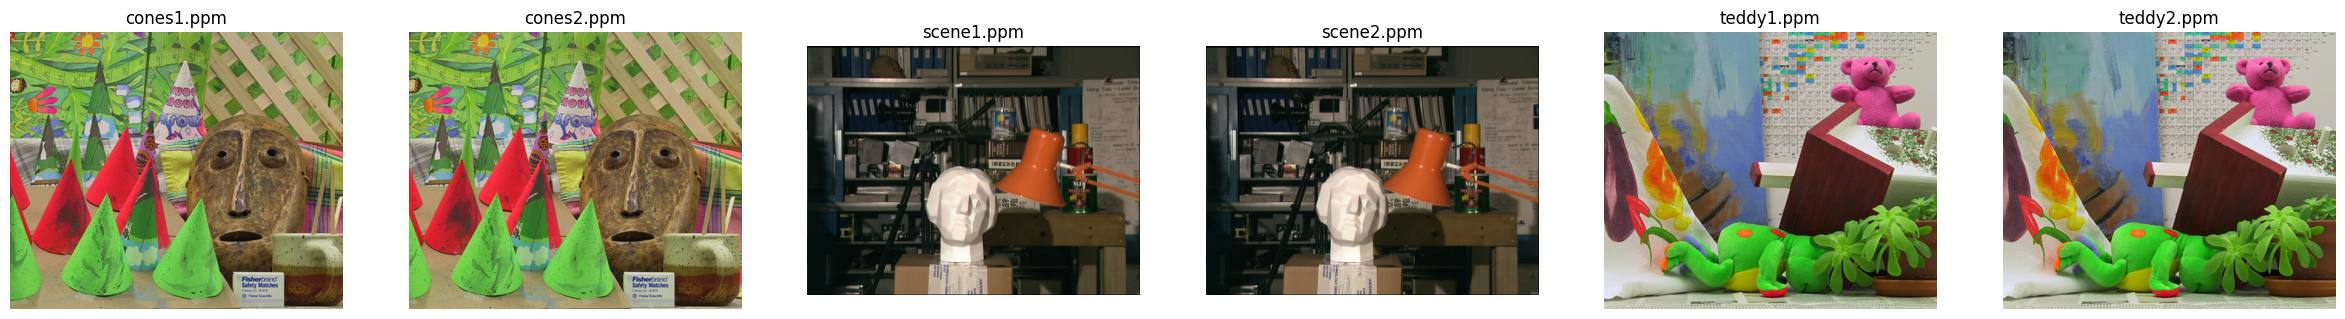

In [241]:
images = []
for image_path in images_paths:
    images.append(cv.imread(image_path))

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(30, 30))
for ax, img, title in zip(axes.flat, images, images_paths):
    ax.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    ax.set_title(f"{title.split('/')[-1]}")
    ax.axis('off')

- Função para plotar os resultados

In [242]:
def plot_images(images):
  fig, axs = plt.subplots(nrows = 1, ncols = 5, figsize = (25, 10))
  titles = ['Original', 'Disparity Map', 'Background', 'Foreground', 'Result']

  for i in range(5):
    axs[i].set_title(titles[i])
    axs[i].axis('off')

    if len(images[i].shape) == 2:
      axs[i].imshow(images[i], cmap='gray')
      
    else:
      images[i] = cv.cvtColor(images[i], cv.COLOR_BGR2RGB)
      axs[i].imshow(images[i])

  plt.show()

- Função para gerar o mapa de disparidade e borrar o fundo da imagem

In [243]:
def dlsr(image_left, image_right, numDisparities, blockSize, thresh):
  h, w = image_left.shape[:2]
  image_right = cv.resize(image_right, (w, h))

  gray_left = cv.cvtColor(image_left, cv.COLOR_BGR2GRAY)
  gray_right = cv.cvtColor(image_right, cv.COLOR_BGR2GRAY)

  stereo = cv.StereoBM_create(numDisparities=numDisparities, blockSize=blockSize)

  disparity = stereo.compute(gray_left, gray_right)
  disparity = cv.medianBlur(disparity, 5)

  mask = (disparity < thresh).astype(np.uint8) * 255

  background = cv.GaussianBlur(image_right, (25, 25), 0)
  foreground = cv.bitwise_and(image_left, image_left, mask=~mask)
  background = cv.bitwise_and(background, background, mask=mask)

  result = cv.add(foreground, background)

  plot_images([image_left, disparity, background, foreground, result])

**Resultado para a imagem 1**:

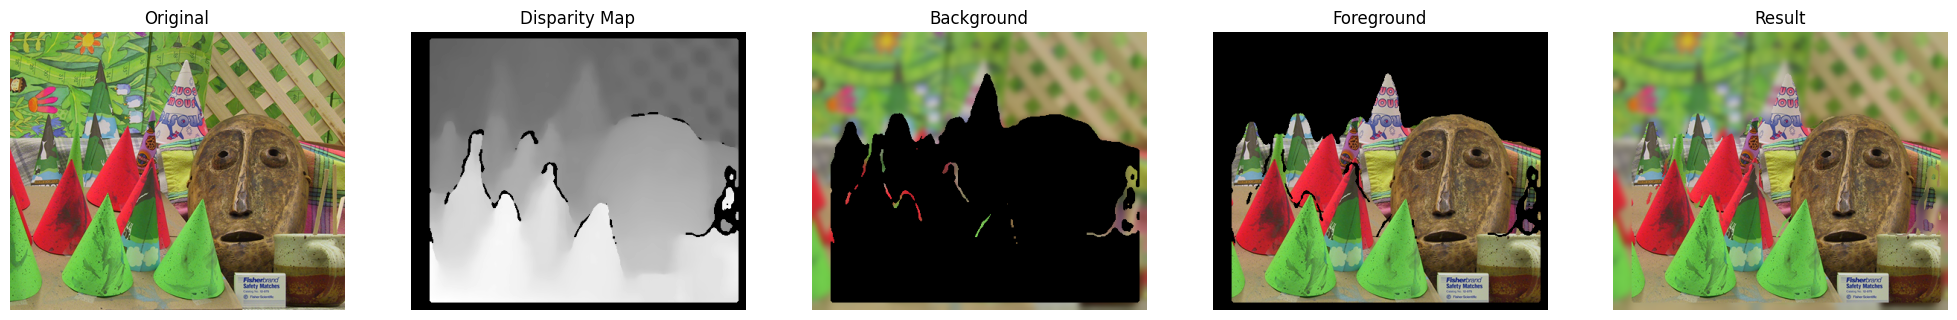

In [244]:
dlsr(images[0], images[1], 16, 21, 100)

**Resultado para a imagem 2**:

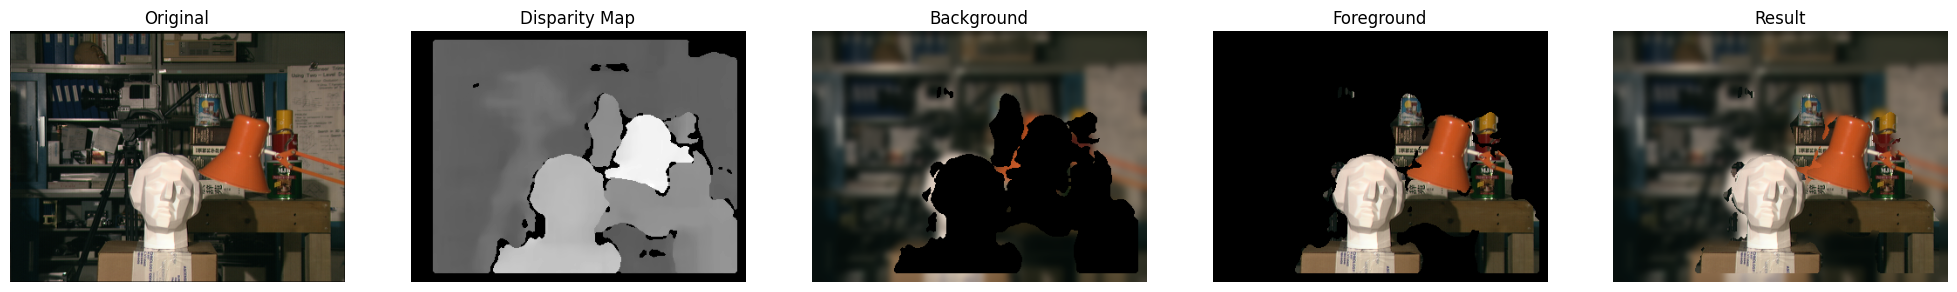

In [245]:
dlsr(images[2], images[3], 16, 21, 100)

**Resultado para a imagem 3**:

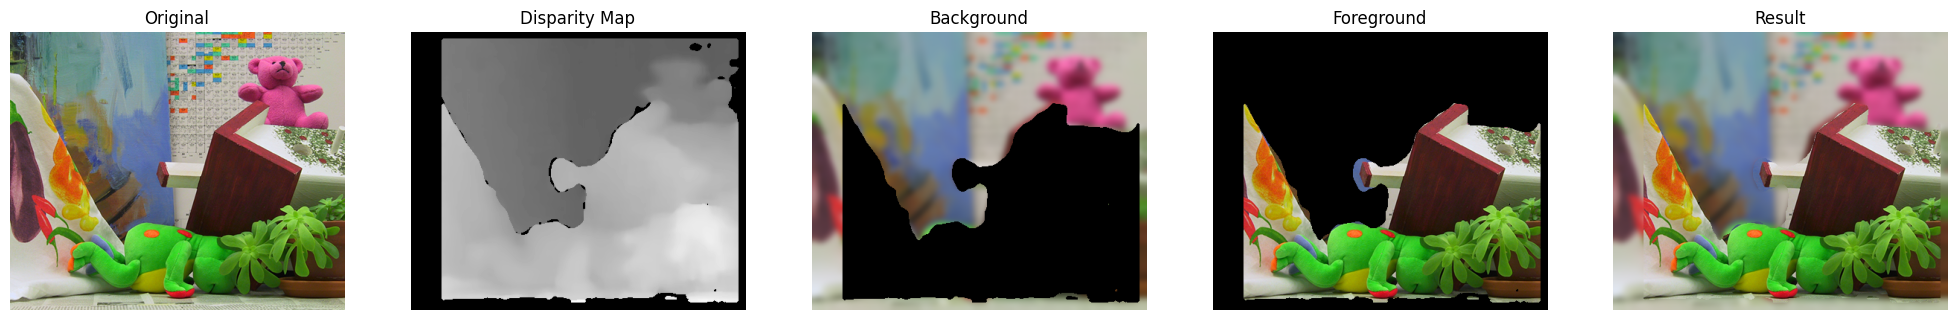

In [246]:
dlsr(images[4], images[5], 32, 21, 110)

### 2. Leia o seguinte tutorial sobre reconstrução 3d, até a etapa de geração do arquivo PLY: https://medium.com/analytics-vidhya/depth-sensing-and-3d-reconstruction-512ed121aa60

#### a) Experimente o código disponibilizado no tutorial em três exemplos distintos, gerando a nuvem de pontos e visualizando com o [Meshlab](https://github.com/cnr-isti-vclab/meshlab/releases).

#### Fluxo de execução

In [247]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [248]:
def showImg(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

def write_ply(fn, verts, colors):
    ply_header = """ply
    format ascii 1.0
    element vertex %(vert_num)d
    property float x
    property float y
    property float z
    property uchar red
    property uchar green
    property uchar blue
    end_header
    """
    out_colors = colors.copy()
    verts = verts.reshape(-1, 3)
    verts = np.hstack([verts, out_colors])
    with open(fn, "wb") as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode("utf-8"))
        np.savetxt(f, verts, fmt="%f %f %f %d %d %d ")   

In [249]:
def calculation(img_left, img_right, ndisp, blocksize, outname):
    # Read color images
    img_left_color = cv2.imread(img_left)
    img_right_color = cv2.imread(img_right)

    # Convert color images to grayscale
    img_left_bw = cv2.blur(cv2.cvtColor(img_left_color, cv2.COLOR_RGB2GRAY),(5,5))
    img_right_bw = cv2.blur(cv2.cvtColor(img_right_color, cv2.COLOR_RGB2GRAY),(5,5))

    # Compute disparity map
    stereo = cv2.StereoBM_create(numDisparities=ndisp, blockSize=blocksize)
    disparity = stereo.compute(img_left_bw, img_right_bw)
    img = disparity.copy()
    plt.imshow(img, 'CMRmap_r')

    # Read calibration matrices from file
    matrix_type_1 = "P2"
    matrix_type_2 = "P3"
    calib_matrix_1 = np.array([])
    calib_matrix_2 = np.array([])

    with open("calib.txt", "r") as f:
        fin = f.readlines()
        for line in fin:
            if line[:2] == matrix_type_1:
                calib_matrix_1 = (
                    np.array(line[4:].strip().split(" "))
                    .astype("float32")
                    .reshape(3, -1)
                )
            elif line[:2] == matrix_type_2:
                calib_matrix_2 = (
                    np.array(line[4:].strip().split(" "))
                    .astype("float32")
                    .reshape(3, -1)
                )

    # Calculate depth-to-disparity
    cam1 = calib_matrix_1[:, :3]  # left image - P2
    cam2 = calib_matrix_2[:, :3]  # right image - P3
    Tmat = np.array([0.5, 0.0, 0.0])

    rev_proj_matrix = np.zeros((4, 4))

    cv2.stereoRectify(cameraMatrix1 = cam1,cameraMatrix2 = cam2, \
                  distCoeffs1 = 0, distCoeffs2 = 0, \
                  imageSize = img_left_color.shape[:2], \
                  R = np.identity(3), T = Tmat, \
                  R1 = None, R2 = None, \
                  P1 =  None, P2 =  None, Q = rev_proj_matrix);

    points = cv2.reprojectImageTo3D(img, rev_proj_matrix)

    # Reflect on x-axis
    reflect_matrix = np.identity(3)
    reflect_matrix[0] *= -1
    points = np.matmul(points, reflect_matrix)

    # Extract colors from image
    colors = cv2.cvtColor(img_left_color, cv2.COLOR_BGR2RGB)

    # Filter by min disparity
    mask = img > img.min()
    out_points = points[mask]
    out_colors = colors[mask]

    # Filter by dimension
    idx = np.fabs(out_points[:, 0]) < 4.5
    out_points = out_points[idx]
    out_colors = out_colors.reshape(-1, 3)
    out_colors = out_colors[idx]

    write_ply(outname + ".ply", out_points, out_colors)
    print(outname, "saved")

    reflected_pts = np.matmul(out_points, reflect_matrix)
    projected_img,_ = cv2.projectPoints(reflected_pts, np.identity(3), np.array([0., 0., 0.]), \
                              cam2[:3,:3], np.array([0., 0., 0., 0.]))
    projected_img = projected_img.reshape(-1, 2)

    blank_img = np.zeros(img_left_color.shape, 'uint8')
    img_colors = img_right_color[mask][idx].reshape(-1,3)

    for i, pt in enumerate(projected_img):
        pt_x = int(pt[0])
        pt_y = int(pt[1])
        if pt_x > 0 and pt_y > 0:
            # use the BGR format to match the original image type
            col = (int(img_colors[i, 2]), int(img_colors[i, 1]), int(img_colors[i, 0]))
            cv2.circle(blank_img, (pt_x, pt_y), 1, col)
    return blank_img

**Resultado para a Imagem 1**

cone saved


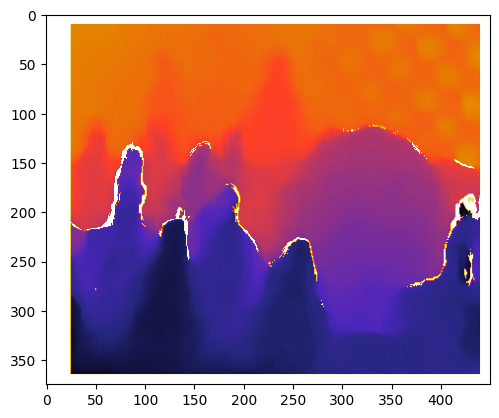

In [250]:
data_folder_left = images_paths[0]
data_folder_right = images_paths[1]
blank_img = calculation(data_folder_left, data_folder_right, 16, 21, "cone")

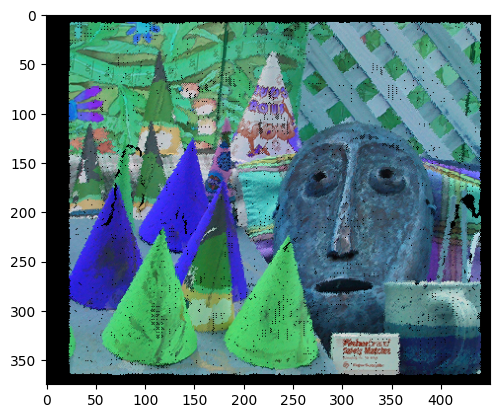

In [251]:
showImg(blank_img)

**Resultado Imagem 2**

/tmp/ipykernel_17184/2664177064.py:57: RuntimeWarning: invalid value encountered in matmul
  points = np.matmul(points, reflect_matrix)


scene saved


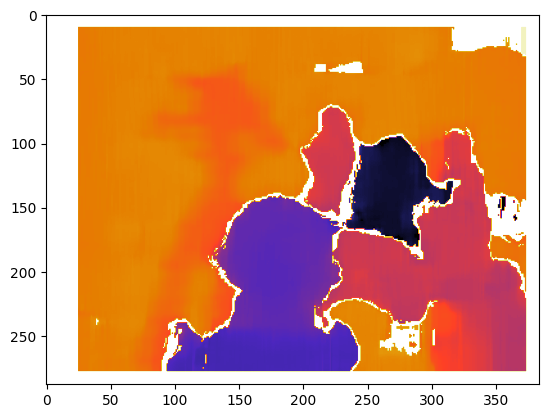

In [252]:
data_folder_left = images_paths[2]
data_folder_right = images_paths[3]
blank_img = calculation(data_folder_left, data_folder_right, 16, 21, "scene")

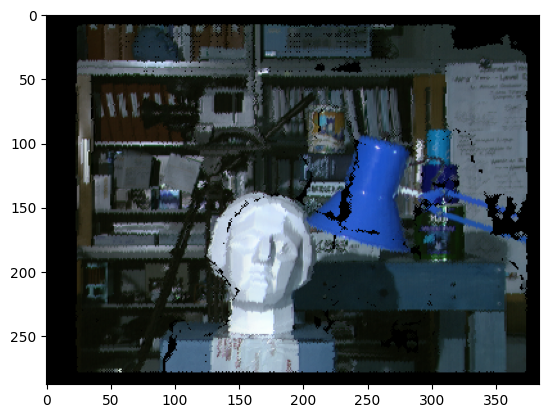

In [253]:
showImg(blank_img)

**Resultado Imagem 3**

teddy saved


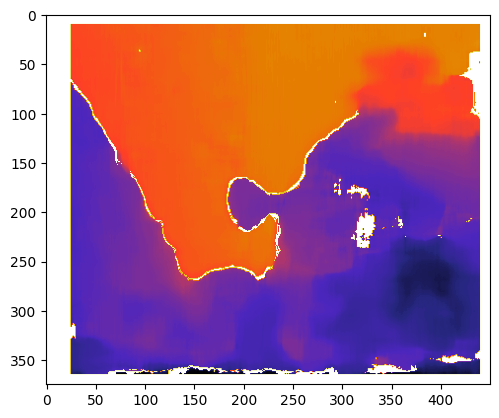

In [254]:
data_folder_left = images_paths[4]
data_folder_right = images_paths[5]
blank_img = calculation(data_folder_left, data_folder_right, 16, 21, "teddy")

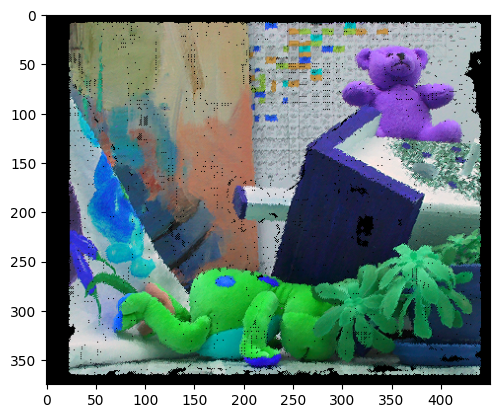

In [255]:
showImg(blank_img)

### **Resultados observados no MeshLAB**

In [256]:
images_paths = [
    'atividade_4_imgs/cone_ml.png',
    'atividade_4_imgs/scene_ml.png',
    'atividade_4_imgs/teddy_ml.png',
]

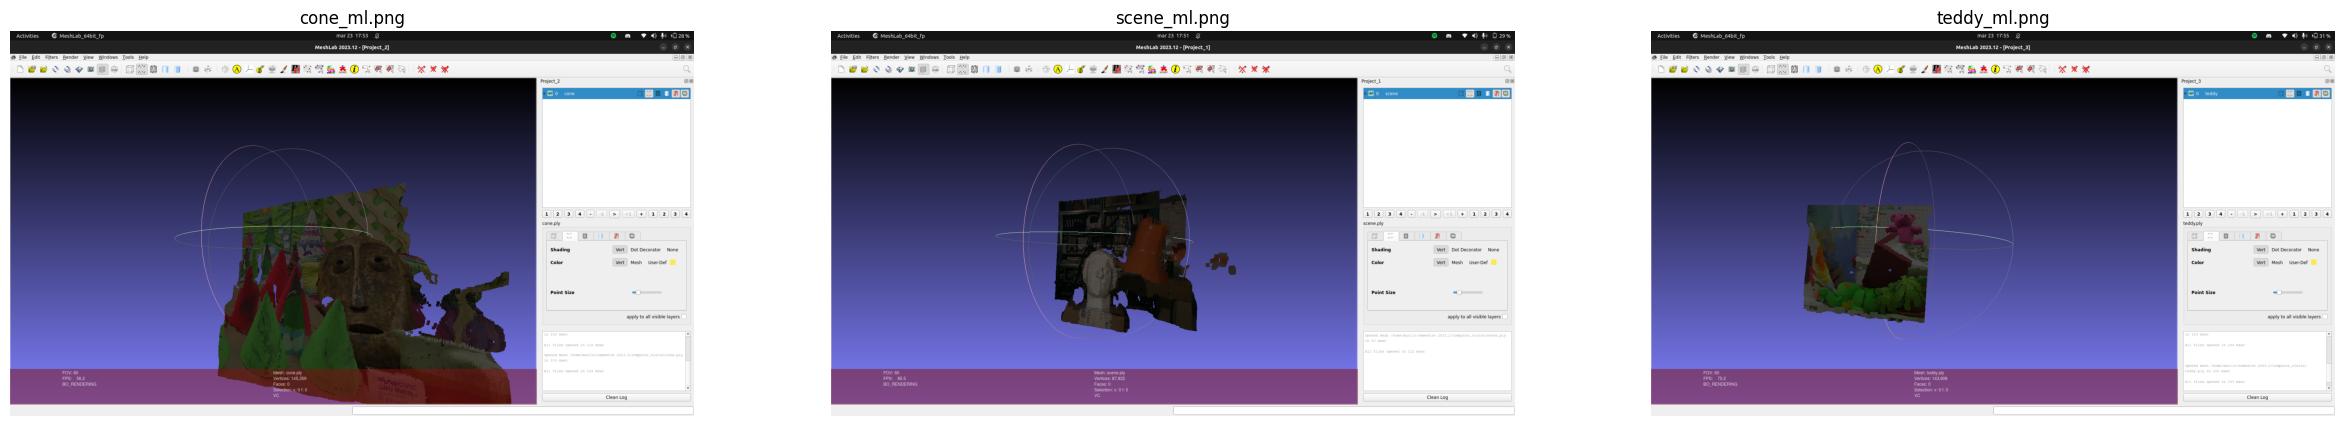

In [257]:
images = []
for image_path in images_paths:
    images.append(cv.imread(image_path))

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 30))
for ax, img, title in zip(axes.flat, images, images_paths):
    ax.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    ax.set_title(f"{title.split('/')[-1]}")
    ax.axis('off')

#### b) Descreva, com suas palavras, as etapas realizadas desde o fornecimento do par de imagens de entrada, até a geração da nuvem de pontos em formato PLY.

### 1. Leitura e Pré-processamento das Imagens
As imagens estéreo são inicialmente carregadas em cores. Este processo é realizado utilizando a função `imread` do OpenCV.

```python
img_left_color = cv2.imread(img_left)
img_right_color = cv2.imread(img_right)
```

### 1. Leitura e pré-processamento das imagens
Inicialmente, as imagens estéreo são lidas em cores. Essa etapa é feita usando a função `imread` do OpenCV para cada uma das imagens esquerda e direita.

```python
img_left_color = cv2.imread(img_left)
img_right_color = cv2.imread(img_right)
```

Posteriormente, as imagens são convertidas para escala de cinza e um desfoque é aplicado para reduzir ruídos. A conversão para escala de cinza e o desfoque são realizados usando `cvtColor` e `blur` do OpenCV.

```python
img_left_bw = cv2.blur(cv2.cvtColor(img_left_color, cv2.COLOR_RGB2GRAY), (5,5))
img_right_bw = cv2.blur(cv2.cvtColor(img_right_color, cv2.COLOR_RGB2GRAY), (5,5))
```

### 2. Cálculo do mapa de disparidade
É criado um mapa de disparidade utilizando a função `StereoBM_create` do OpenCV, a partir das imagens em escala de cinza. O mapa de disparidade é calculado pela função `compute` do objeto `stereo`.

```python
stereo = cv2.StereoBM_create(numDisparities=ndisp, blockSize=blocksize)
disparity = stereo.compute(img_left_bw, img_right_bw)
```

### 3. Leitura das matrizes de calibração
As matrizes de calibração são lidas de um arquivo de texto. Cada linha do arquivo é analisada, e as matrizes são extraídas e convertidas em arrays numpy.

```python
with open("calib.txt", "r") as f:
    fin = f.readlines()
    for line in fin:
        if line[:2] == matrix_type_1:
            calib_matrix_1 = np.array(line[4:].strip().split(" ")).astype("float32").reshape(3, -1)
        elif line[:2] == matrix_type_2:
            calib_matrix_2 = np.array(line[4:].strip().split(" ")).astype("float32").reshape(3, -1)
```

### 4. Conversão de disparidade para profundidade
A matriz de projeção reversa é calculada usando a função `stereoRectify` e `reprojectImageTo3D` do OpenCV. Isso transforma o mapa de disparidade em uma imagem de profundidade 3D.

```python
rev_proj_matrix = np.zeros((4, 4))
cv2.stereoRectify(cam1, cam2, 0, 0, img_left_color.shape[:2], R=np.identity(3), T=Tmat, Q=rev_proj_matrix)
points = cv2.reprojectImageTo3D(disparity, rev_proj_matrix)
```

### 5. Geração da nuvem de pontos 3D
Os pontos 3D são filtrados e refletidos para corrigir a orientação. Cada ponto 3D é associado com sua cor correspondente na imagem esquerda.

```python
reflect_matrix = np.identity(3)
reflect_matrix[0] *= -1
points = np.matmul(points, reflect_matrix)
colors = cv2.cvtColor(img_left_color, cv2.COLOR_BGR2RGB)
```

### 6. Exportação para arquivo PLY
A nuvem de pontos é salva em um arquivo PLY usando a função `write_ply`. O arquivo PLY contém tanto as coordenadas espaciais dos pontos quanto suas cores RGB.

```python
write_ply(outname + ".ply", out_points, out_colors)
```

### A implementação para os itens 3 e 4 está presente no google colab no seguinte [link](https://colab.research.google.com/drive/1MMokQiTELVzFSEKF0fhNn45tbEhrvELS#scrollTo=2WyIBSZA4mvU)